<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/!!HW_16_text_classification_sci_kit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK: Perform reviews' classification into positive and negative. Use sci-kit learn.**

**Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews**

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from scipy.sparse import hstack

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from wordcloud import WordCloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset.**

In [ ]:
# Завантажимо наш датасет
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")

**Let's take a look at its contents.**

In [ ]:
# Подивимось на його зміст
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**We see the reviews and their ratings. Let's take a look at the information about the dataset.**

In [ ]:
# Бачимо відгуки і їх оцінку. Подивимось додатково інформацію по датасету

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


**There are no missing values, so we can proceed.**

In [ ]:
# Пропущених значень немає, йдемо далі

**Let's build a diagram of the 'sentiment' column values to see the count of positive and negative reviews.**

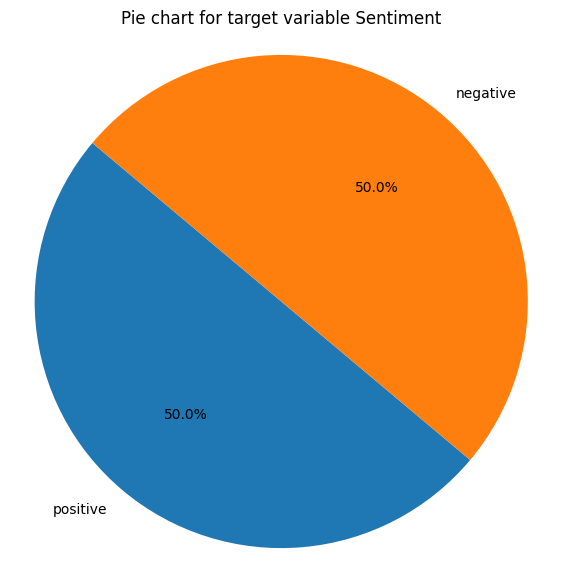

In [ ]:
# Будуємо діаграму значень колонки sentiment, щоб подивитися кількість позитивних та негативних відгуків
sentiment_counts = df["sentiment"].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Pie chart for target variable Sentiment")
plt.axis("equal")
plt.show()

**We see that there are an equal number of positive and negative reviews, so the classifier is likely to perform evenly across both classes.**

In [ ]:
# Бачимо, що позитивних та негативних відгуків однакова кількість, тож, скоріш за все, класифікатор має рівномірно спрацювати на обох класах

**It would be interesting to take a look at key words separately in positive and negative reviews. So, let's do this using a WordCloud.**

In [ ]:
# Цікаво було б подивитися на ключові слова окремо у позитивних та негативних відгуках. Тож зробимо це за допомогою WordCloud

In [ ]:
# Splitting the text into positive reviews.
# Спочатку розділимо текст на
# позитивні відгуки
positive_reviews = df[df["sentiment"] == "positive"]["review"].values
positive_text = ' '.join(positive_reviews)

# Splitting the text into negative reviews.
# негативні відгуки
negative_reviews = df[df["sentiment"] == "negative"]["review"].values
negative_text = ' '.join(negative_reviews)

**Creating a WordCloud for positive and negative reviews.**

In [ ]:
# Тепер створюємо WordCloud для позитивних та негативних відгуків
positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)

negative_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

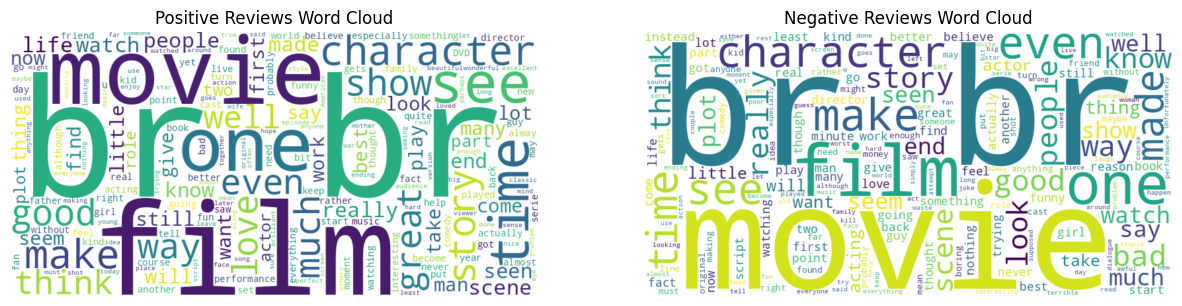

In [ ]:
# Будуємо WordCloud
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# for positive reviews
# для позитивних відгуків
axes[0].imshow(positive_wordcloud, interpolation="bilinear")
axes[0].set_title("Positive Reviews Word Cloud")
axes[0].axis("off")

# for negative reviews
# для негативних відгуків
axes[1].imshow(negative_wordcloud, interpolation="bilinear")
axes[1].set_title("Negative Reviews Word Cloud")
axes[1].axis("off")

plt.show()

**So, we can see that for both classes, we have two main common keywords - "movie" and "film", which makes sense since our dataset consists of movie reviews. We also have tags that we will remove later. Additionally, we observe secondary keywords that characterize movies directly, and there are many similarities in both classes. However, there is a significant difference as well: for instance, the presence of words that can classify reviews such as "great", "fun" on the "positive" map, and "terrible", "waste" on the "negative" map. We can also notice that words that seemingly characterize both positive and negative sentiments, like "good" and "bad", are present in both classes, but judging by their size in the WordCloud, we can determine which class they are more important for. Overall, the WordCloud effectively displays key words in the text that can help identify the subject matter, especially when we have no prior information about it. However, it is challenging to pinpoint specific factors influencing classification solely based on this map.**

In [ ]:
# Отже, бачимо, що для обох класів маємо 2 однакових основних ключових слова - movie, film, що логічно, так як наш датасет - це відгуки на фільми.
# Ще маємо теги, які пізніше видалимо.
# Також бачимо другорядні ключові слова, що характеризують безпосередньо фільми, і їх теж дуже багато однакових в обох класах
# Але є і принципова різниця: наприклад, присутність слів, що можуть класифікувати відгуки:
# great, fun - на "позитивній" мапі, та, terrible, waste на "негативній".

# Можна помітити, що такі, начебто добре характеризуючі слова, як наприклад, good та bad, є в обох класах, але судячи з їх "розміру",
# то можна визначити для якого класу вони є важливішими

# Загалом WordCloud добре показує ключові слова тексту, по яким можна +- визначити про що йде мова, якщо,
# наприклад, в нас немає про це ніякої попередньої інформаціі.
# Але по такій мапі важкувато виділити, що конкретно впливає на класифікацію.

**So, let's start preparing the data for further classification.**

In [ ]:
# Тож, почнімо готувати дані для подальшої класифікації

**First, let's remove the tags.**

In [ ]:
# Спочатку видалимо теги
df["review"] = df["review"].str.replace("<br /><br />", "")

**Loading the list of stop words for the English language.**

In [ ]:
# Загружаємо список стоп-слів для англійської мови
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Removing stop words.**

In [ ]:
# Видаляємо стоп-слова
df["review"] = df["review"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

**Converting classes into numbers.**

In [ ]:
# Переводимо класи в числа
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

**Adding a new feature - text length.**

In [ ]:
# Додамо нову фічу - довжину тексту
df["text_length"] = df["review"].apply(lambda x: len(x))

**Splitting the dataset into features and target variables.**

In [ ]:
# Розділяємо датасет на ознаки та цільову змінну
X = df[["review", "text_length"]]
y = df["sentiment"]

**Scaling of the numerical feature.**

In [ ]:
# Застосовуємо скалер до числової ознаки
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled.loc[:, ["text_length"]] = scaler.fit_transform(X_scaled[["text_length"]])

**Splitting the dataset into training, validation, and test samples.**

In [ ]:
# Розділяємо датасет на тренувальну, тестову та валідаційну частини
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

**Vectorization of the textual variable.**

In [ ]:
# Робимо векторизацію текстової змінної
vectorizer = TfidfVectorizer(max_features=10000)
X_train_text = vectorizer.fit_transform(X_train["review"])
X_test_text = vectorizer.transform(X_test["review"])
X_val_text = vectorizer.transform(X_val["review"])

In [ ]:
print(X_train_text)

  (0, 3855)	0.09607467285692951
  (0, 8563)	0.06487106857492374
  (0, 8844)	0.10553819556680019
  (0, 5321)	0.0783447453285528
  (0, 4083)	0.19946120187721245
  (0, 2087)	0.2025738317794024
  (0, 8702)	0.20824026915788987
  (0, 1091)	0.170165092568079
  (0, 8089)	0.19034834208284038
  (0, 5630)	0.14792725955962457
  (0, 9751)	0.06482900724266626
  (0, 6549)	0.10093950655577856
  (0, 3937)	0.058065211474078074
  (0, 9296)	0.12176688486431618
  (0, 973)	0.0778650551517867
  (0, 9279)	0.10929140276591716
  (0, 6075)	0.1092279279377844
  (0, 8969)	0.07577187862637254
  (0, 7686)	0.10514927031527611
  (0, 4185)	0.19396251529259623
  (0, 4472)	0.10820602602315693
  (0, 3854)	0.0682011308235342
  (0, 9971)	0.1419187028649877
  (0, 6066)	0.09139930278421841
  (0, 2828)	0.16226417231925352
  :	:
  (34999, 7228)	0.09231588342506471
  (34999, 5461)	0.059346748850900355
  (34999, 228)	0.12582112113564642
  (34999, 241)	0.0739129768102677
  (34999, 1266)	0.0938014602134248
  (34999, 9045)	0.0990382

**From the numbers nothing is understood, but we can take a look, for example, at the 20 most frequently used words.**

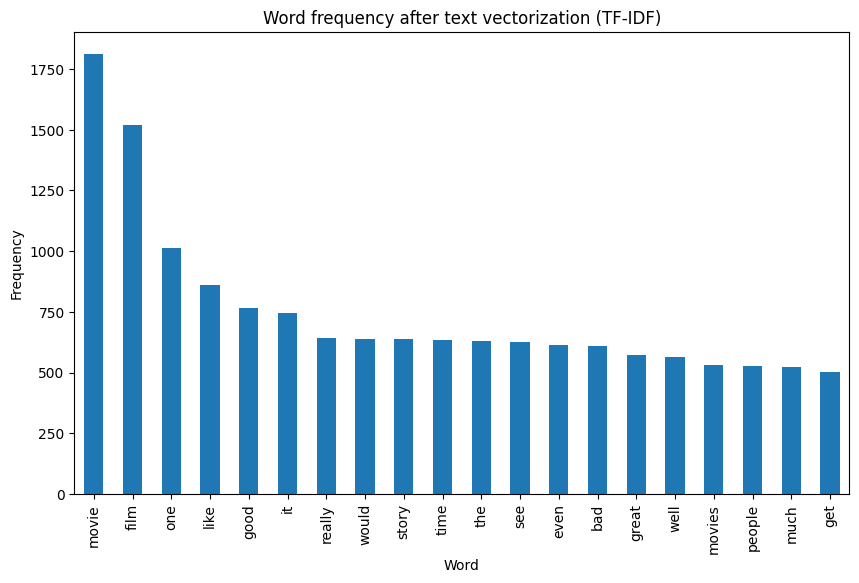

In [ ]:
# З чисел нічого не зрозуміло, але можна подивитися, наприклад, на 20 найчастіше використаних слів
X_array = X_train_text.toarray()
df_vector = pd.DataFrame(X_array, columns=vectorizer.get_feature_names_out())

plt.figure(figsize=(10, 6))
df_vector.sum().sort_values(ascending=False)[:20].plot(kind='bar')
plt.title("Word frequency after text vectorization (TF-IDF)")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

**So, we can see the top 20 basic words used in the reviews. These are already familiar undeniable leaders like "movie" and "film," which we've already seen on the wordcloud map. There are also our descriptors "good" and "bad," and the main verbs: "like," "see," "get." Initially, I built a similar graph without removing stop words, and they were at the top. In my opinion, the graph was losing its meaningful value, so I decided to rework it and remove the noise.**

In [ ]:
# Отже бачимо топ-20 основних слів, що використовуються у відгуках. Це вже знайомі нам беззаперечні лідери movie та film,
# які ми вже бачили на мапі wordcloud.
# Також є наші характеристики good та bad, і основні дієслова: like, see, get.

# Спочатку будувала такий же графік не видаляючи стоп-слова,
# ну і в топі були саме вони. Як на мене графік втрачав смислове значення, тож вирішила переробити і повидаляти шум

**Combining textual and numerical features across all samples.**

In [ ]:
# Йдемо далі і комбінуємо текстову та числову ознаки на всих наборах даних
X_train_combined = hstack((X_train_text, X_train[["text_length"]].values))
X_test_combined = hstack((X_test_text, X_test[["text_length"]].values))
X_val_combined = hstack((X_val_text, X_val[["text_length"]].values))

**Creating and training a Linear Support Vector Machine Model.**

In [ ]:
# Створюємо та навчаємо модель Linear Support Vector Machine:
model = LinearSVC(max_iter=5000)
model.fit(X_train_combined, y_train)

LinearSVC(max_iter=5000)

**Calculating the evaluation on the training and test samples.**

In [ ]:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = model.score(X_train_combined, y_train)
test_score = model.score(X_test_combined, y_test)
print("Train Score LinearSVC:", train_score)
print("Test Score LinearSVC:", test_score)

Train Score LinearSVC: 0.9608571428571429
Test Score LinearSVC: 0.8894666666666666


**The data seems gut, but the almost 1% difference in scores between the training and test samples is quite large.**

In [ ]:
# Начебто дані непогані, але мені не дуже подобається різниця в майже 1% між скорами на трейн і тест вибірках

**Evaluation of the LinearSVC model.**

In [ ]:
# Робимо додатково оцінку моделі LinearSVC
y_pred = model.predict(X_test_combined)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3722
           1       0.88      0.90      0.89      3778

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



**Here the overall picture is normal, with quite high ratings.**

In [ ]:
# Тут в принципі картина нормальна, досить високі оцінки

**Creating LogisticRegression model.**

In [ ]:
# Спробуємо ще модель LogisticRegression
lr_model = LogisticRegression(max_iter=5000, random_state=42)
lr_model.fit(X_train_combined, y_train)

LogisticRegression(max_iter=5000, random_state=42)

**Calculating the evaluation on the training and test samples**

In [ ]:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score_lr = lr_model.score(X_train_combined, y_train)
test_score_lr = lr_model.score(X_test_combined, y_test)
print("Train Score Logistic Regression:", train_score_lr)
print("Test Score Logistic Regression:", test_score_lr)

Train Score Logistic Regression: 0.9248285714285714
Test Score Logistic Regression: 0.8977333333333334


**Here the score on the train set is 0.4 lower, and on the test set it's 0.1 higher compared to the LinearSVC model. But these estimates seem more realistic to me.**

In [ ]:
# Тут скор на трейн виборці менше на 0.4, а на тест на 0.1 більше, ніж в моделі LinearSVC.
# Але, як на мене, саме ці оцінки виглядають більш реальними

**Let's look at the evaluation of the LogisticRegression model.**

In [ ]:
# Дивимось оцінку моделі LogisticRegression
y_pred_logistic = lr_model.predict(X_test_combined)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3722
           1       0.89      0.91      0.90      3778

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



**Here the picture, although only by 1%, is better in all metrics compared to LinearSVC.**

In [ ]:
# Тут картина хоч і всього на 1%, але краща по всім показникам, в порівнянні з LinearSVC.

In [ ]:
# tuning hyperparameters for LogisticRegression:
# Підберемо ще гіперпараметри для LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_val_combined, y_val)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [ ]:
# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_lr_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_
print("Best LR Parameters:", best_lr_params)
print("Best LR Model:", best_lr_model)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_accuracy_lr = best_lr_model.score(X_val_combined, y_val)
print("Validation LR Accuracy:", valid_accuracy_lr)

Best LR Parameters: {'C': 1}
Best LR Model: LogisticRegression(C=1, max_iter=5000, random_state=42)
Validation LR Accuracy: 0.9357333333333333


**Therefore, for LogisticRegression, we achieved an accuracy that is +3.5% higher. We will consider the LogisticRegression model the best for this dataset. Overall, it can be said that the classification was successful. The metrics for both classes are sufficiently high, and it can also be added that the model "finds" each class approximately equally well.**

In [ ]:
# Отже, для LogisticRegression отримуємо accuracy ще +3.5% більше. Будемо вважати модель LogisticRegression найкращою для даного датасету.

# Загалом можна сказати, що класифікація пройшла успішно. Показники по обом класам достатньо високі,
# і можна ще додати, що модель +- однаково "знаходить" той чи інший клас.